In [1]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkorange','darkblue','forestgreen','purple']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen']



In [2]:
# Downloading data, then unzipping manually in folder, then preprocessing with below code from Psytrack notebook

# current_cwd = os.getcwd()
# SPATH = current_cwd + "/Figures"
# ibl_data_path = SPATH + '/ibl-behavioral-data-Dec2019'
# # os.chdir(ibl_data_path)
# # print(os.getcwd())

# # import subprocess

# # def runcmd(cmd, verbose = False, *args, **kwargs):

# #     process = subprocess.Popen(
# #         cmd,
# #         stdout = subprocess.PIPE,
# #         stderr = subprocess.PIPE,
# #         text = True,
# #         shell = True
# #     )
# #     std_out, std_err = process.communicate()
# #     if verbose:
# #         print(std_out.strip(), std_err)
# #     pass

# # runcmd('echo "Hello, World!"', verbose = True)

# # runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

In [3]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll.head()

contrastLeft  contrastRight  choice  feedbackType  probabilityLeft  \
0           1.0            0.0       1             0              1.0   
1           1.0            0.0       1             0              1.0   
2           0.0            1.0       1             1              1.0   
3           0.5            0.0       0             1              0.5   
4           0.5            0.0       0             1              0.9   

           lab subject        date  session  correctSide  
0  angelakilab  IBL-T1  2019-02-09        1            0  
1  angelakilab  IBL-T1  2019-02-09        1            0  
2  angelakilab  IBL-T1  2019-02-09        1            1  
3  angelakilab  IBL-T1  2019-02-09        1            0  
4  angelakilab  IBL-T1  2019-02-09        1            0

In [4]:
data = dfAll[dfAll['subject']=='ibl_witten_15']
print(data['probabilityLeft'])

3327480    0.5
3327481    0.5
3327482    0.9
3327483    0.5
3327484    0.8
          ... 
3397128    0.8
3397129    0.8
3397130    0.8
3397131    0.8
3397132    0.8
Name: probabilityLeft, Length: 69653, dtype: float64


In [5]:
print("contrastLeft: ", np.unique(dfAll['contrastLeft']))   # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("contrastRight: ", np.unique(dfAll['contrastRight'])) # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("choice: ", np.unique(dfAll['choice']))               # [0, 1]
print("feedbackType: ", np.unique(dfAll['feedbackType']))   # [0, 1]
print("correctSide: ", np.unique(dfAll['correctSide']))               # [0, 1]
print("lab: ", np.unique(dfAll['lab']))

contrastLeft:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
choice:  [0 1]
feedbackType:  [0 1]
correctSide:  [0 1]
lab:  ['angelakilab' 'churchlandlab' 'cortexlab' 'danlab' 'hoferlab' 'mainenlab'
 'mrsicflogellab' 'wittenlab' 'zadorlab']


In [12]:
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


# dGLM-HMM with sigma=0 from cluster - getting same best fits for sign=-1 and sign=1 up to minus sign 
# => keeping sign=1 and then plotting -weights

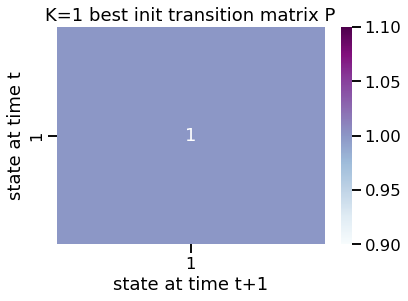

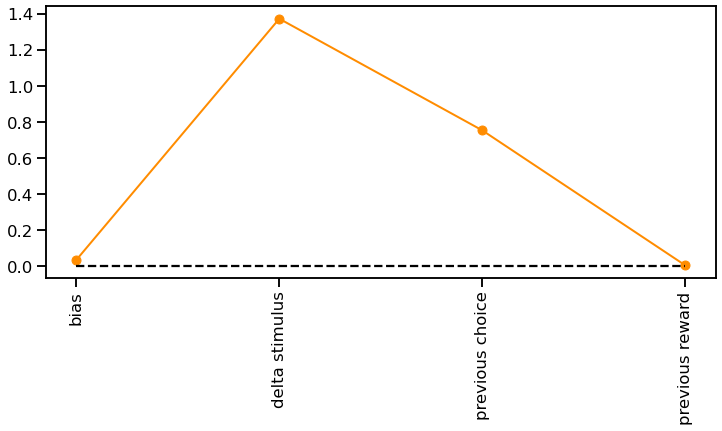

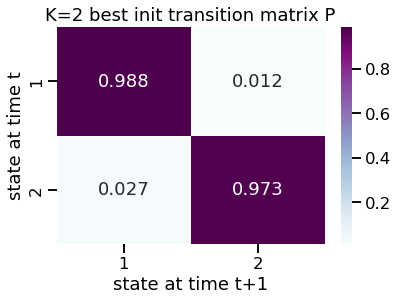

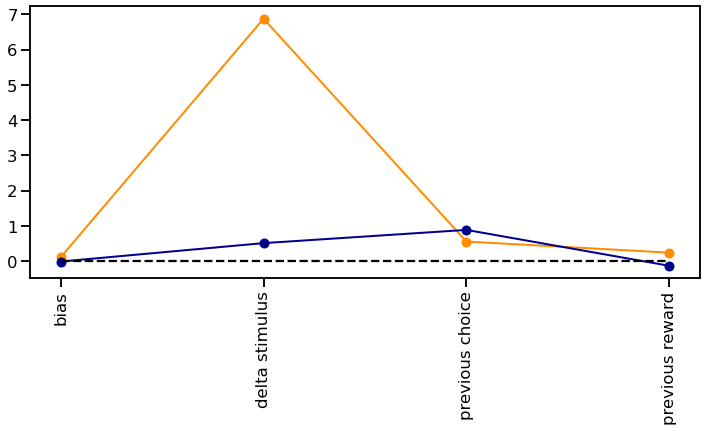

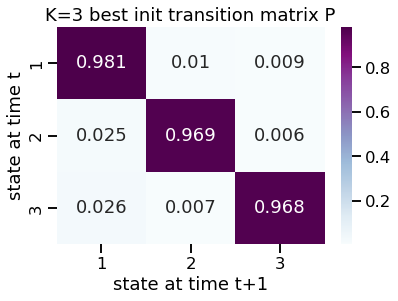

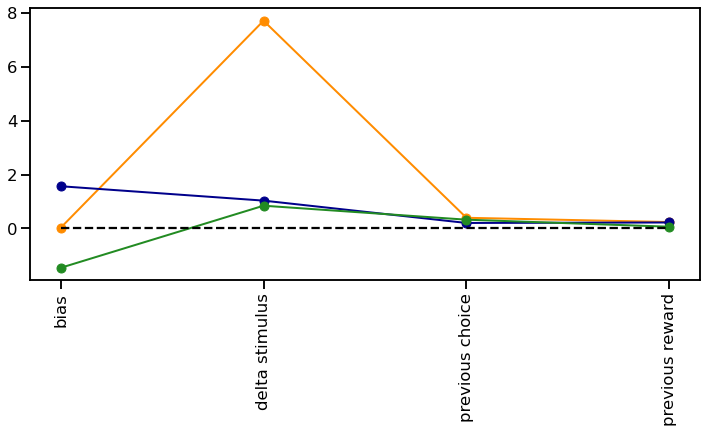

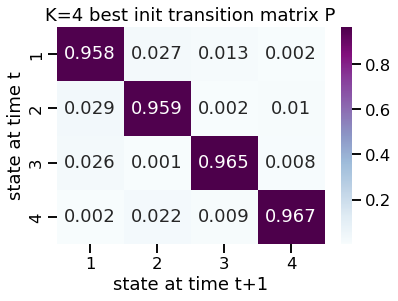

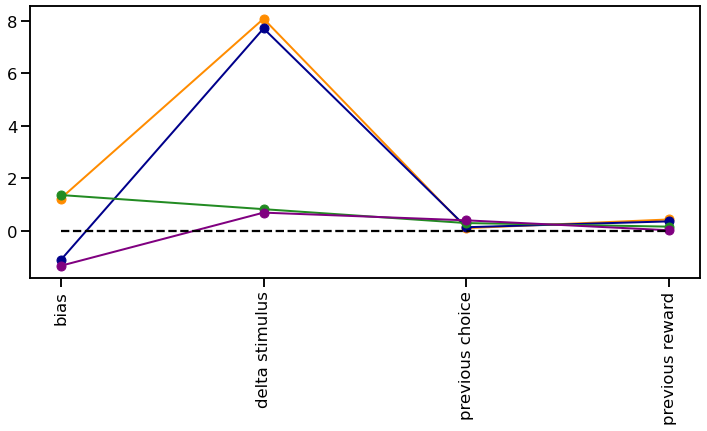

In [12]:
inits = 20
ll = np.zeros((inits, 3, 2), dtype=object)
P = np.zeros((inits, 3, 2), dtype=object)
W = np.zeros((inits, 3, 2), dtype=object)
D = 4
df = pd.DataFrame(columns=['init','K', 'sign', 'll', 'acc' ,'P', 'W']) # in total z=0,159
z = 0

sessInd = np.load(f'../data_IBL/sessInd_allAnimals_D={D}.npy')

inits = 20
for K in [1,2,3,4]:
    for sign in [-1, +1]:
        llAll = np.zeros((inits))
        for init in range(0, inits):
            df.loc[z, 'init'] = init
            df.loc[z, 'K'] = K
            df.loc[z, 'sign'] = sign
            df.loc[z, 'll'] = np.load(f'../data_IBL/all/Ll_allAnimals_D={D}_{K}_state_init-{init}_sign={sign}_sigma=0.npy')[0]
            df.loc[z, 'acc'] = np.load(f'../data_IBL/all/Ll_allAnimals_D={D}_{K}_state_init-{init}_sign={sign}_sigma=0.npy')[1]
            df.loc[z, 'P'] = np.load(f'../data_IBL/all/P_allAnimals_D={D}_{K}_state_init-{init}_sign={sign}_sigma=0.npy')
            df.loc[z, 'W'] = np.load(f'../data_IBL/all/W_allAnimals_D={D}_{K}_state_init-{init}_sign={sign}_sigma=0.npy')

            llAll[init] = df.loc[z, 'll']
            z += 1

        # get the index of the top ll
        bestInd = np.argmax(llAll)
        dfTemp = df[df['K'] == K]
        dfTemp = dfTemp[dfTemp['sign']==sign]
        dfTemp = dfTemp[dfTemp['init']==bestInd]
        dfTemp = dfTemp.reset_index()

        if (sign==1): # contrastRight - contrastLeft

            fig, axes = plt.subplots()
            sortedStateInd = get_states_order(dfTemp.loc[0,'W'], [0, dfTemp.loc[0,'W'].shape[0]], stimCol=[1]) # in the GLM-HMM
            plot_transition_matrix(dfTemp.loc[0,'P'], title=f'K={K} best init', sortedStateInd=sortedStateInd)
            fig, axes = plt.subplots(1, figsize=(12,5))
            # fig.suptitle(f'K={K} best init')
            plot_constant_weights(dfTemp.loc[0,'W'], axes, xlabels=myFeatures[0], colors=colorsStates, sign=-sign, sortedStateInd=sortedStateInd)

            # sorting the states in order
            p = dfTemp.loc[0,'P'][sortedStateInd,:][:,sortedStateInd]
            w = dfTemp.loc[0,'W'][:,sortedStateInd,:,:]

            # saving best models
            np.save(f'../data_IBL/Best_sigma=0_allAnimals_D={D}_{K}-state_P.npy', p)
            np.save(f'../data_IBL/Best_sigma=0_allAnimals_D={D}_{K}-state_W.npy', w[0].reshape(1,w.shape[1],w.shape[2],w.shape[3]))

        



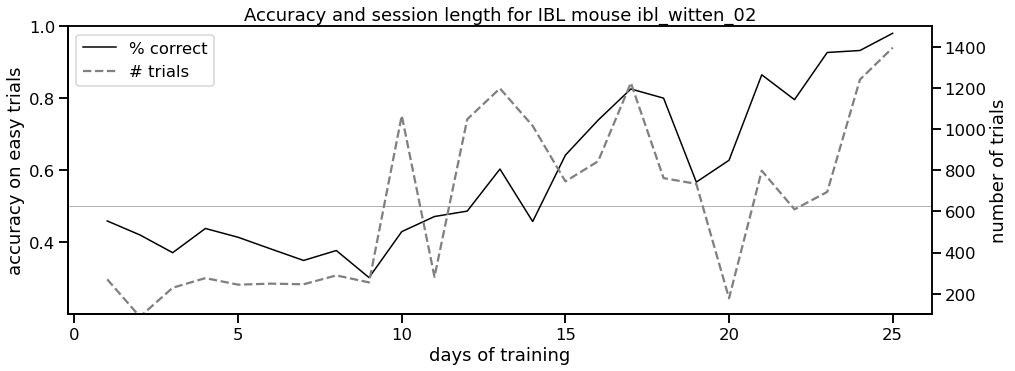

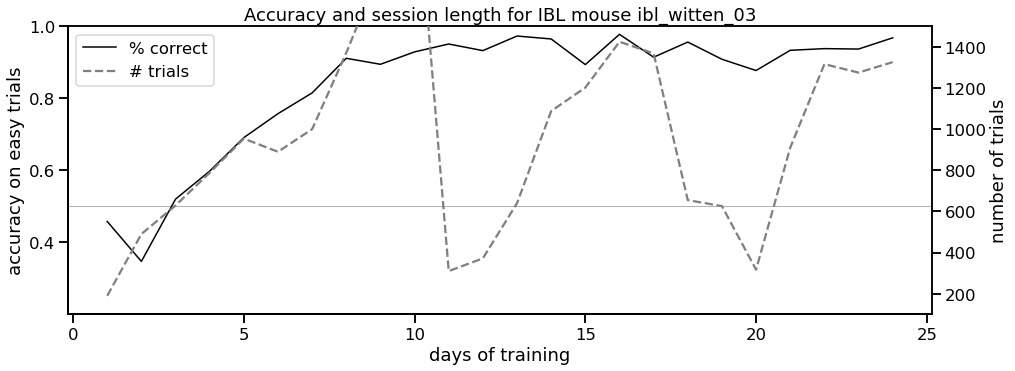

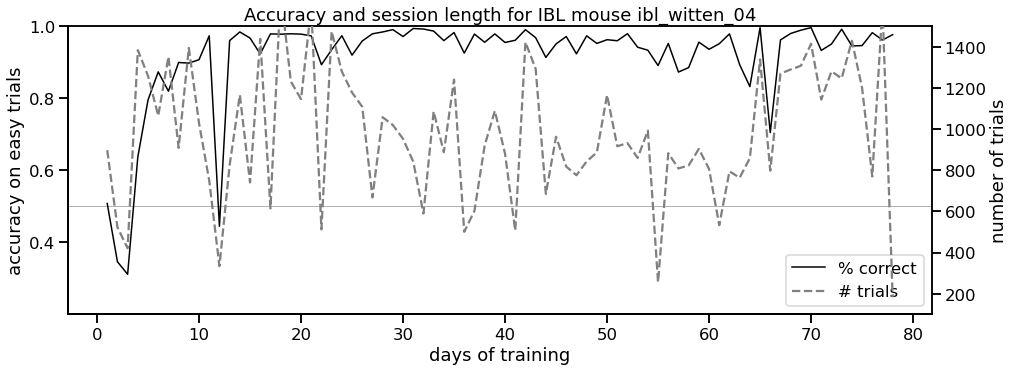

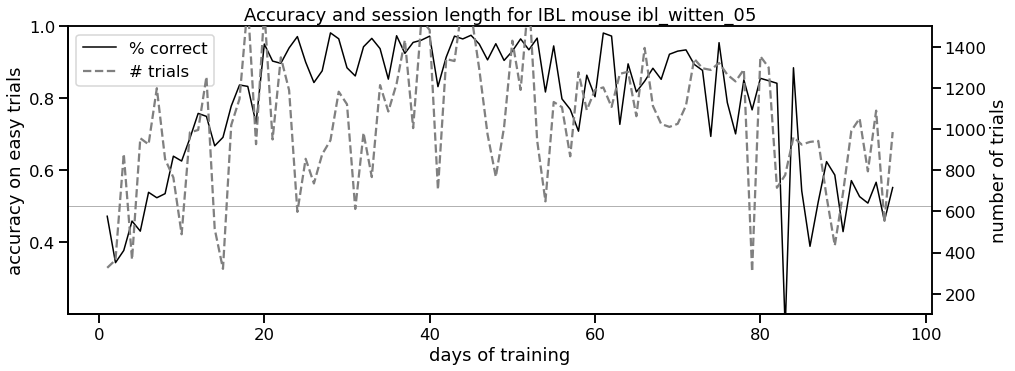

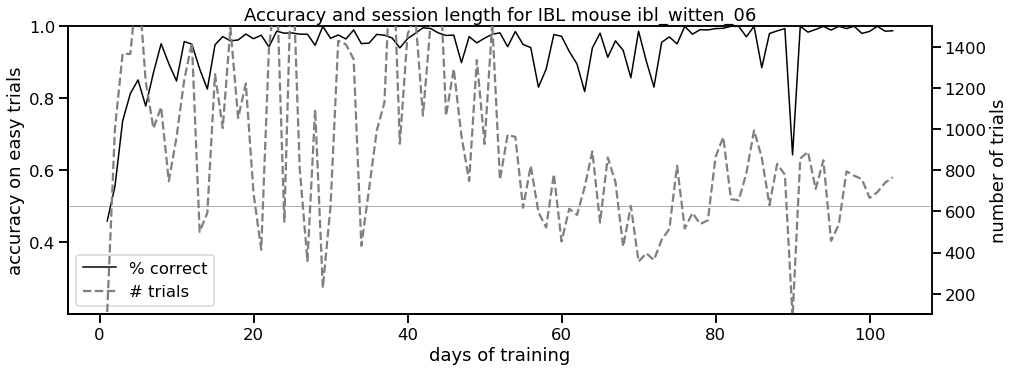

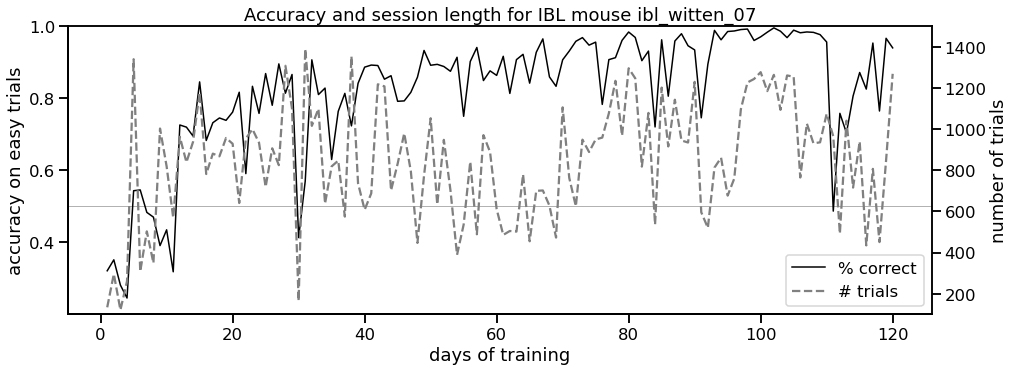

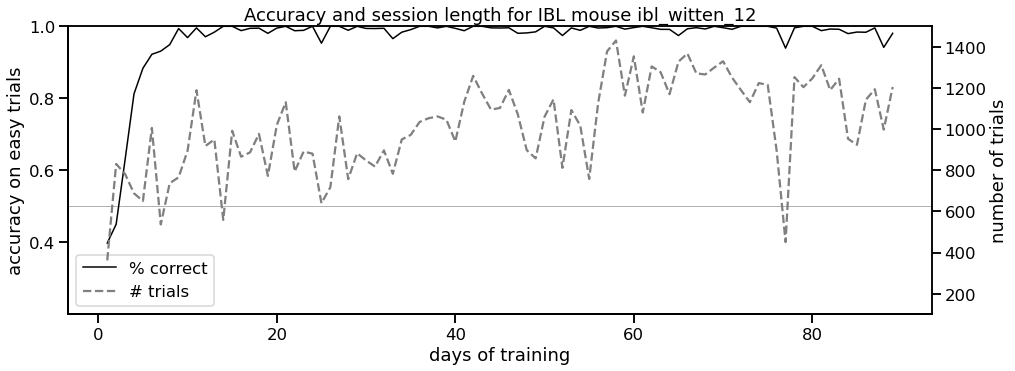

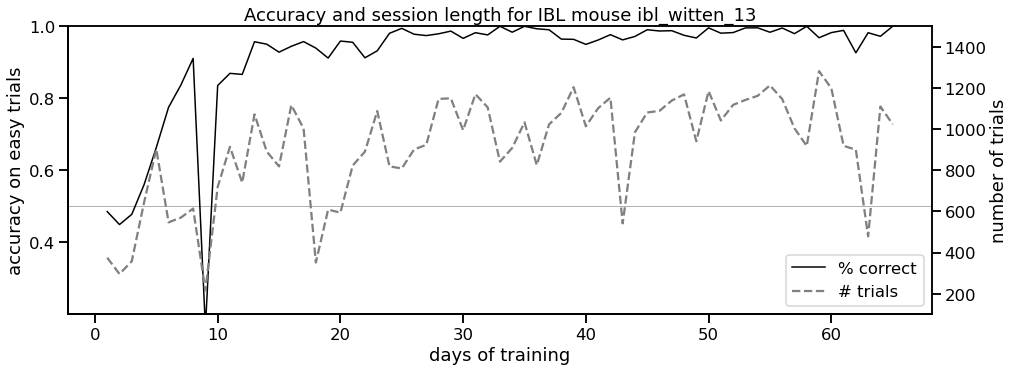

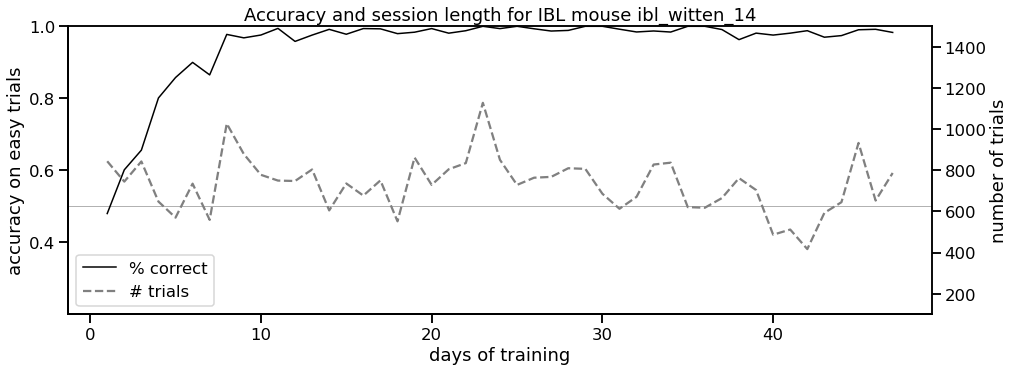

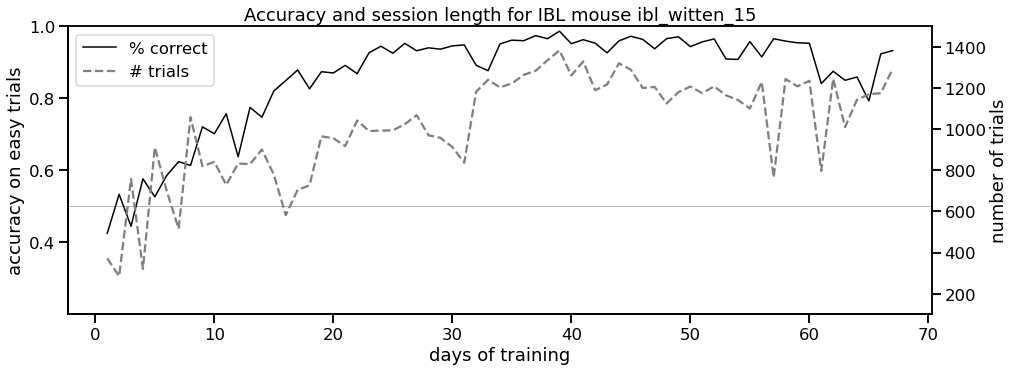

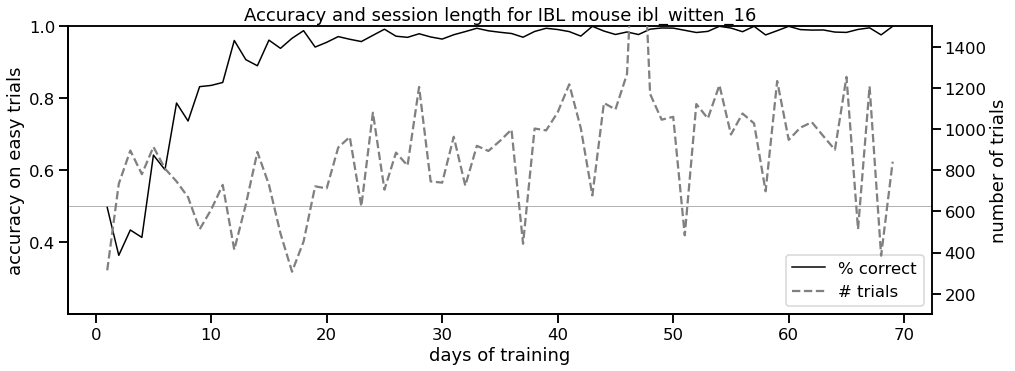

In [64]:
for subject in subjectsWitten: 
    fig = plt.figure(figsize=(12,4))
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    axes = [ax1,ax2]
    IBL_plot_performance(dfAll, subject=subject, axes=axes, sessStop=-1)


In [5]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4

D = 4 # number of features
subject = 'ibl_witten_15'
K = 2

# last session to use in fitting
sessStop = -1
x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET

In [6]:
glmhmmW = np.load(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')
glmhmmP = np.load(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')

trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=splitFolds, blocks=10, random_state=1)
fold = 3
trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_2Dsigmas(trainX[fold], trainY[fold], trainSessInd[fold], testX[fold], testY[fold], testSessInd[fold], K, sigmaList=[1, 100], maxiter=2, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=1, priorDirP = [10,1], stimCol=[1])

# Fitting K=1,2,3 dGLM-HMM1 with CV for folds=4 until session sessStop=40 for D=3

In [ ]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one

D = 5 # number of features

# last session to use in fitting
sessStop = -1

In [ ]:
# fitting for K = 1,2,3

for K in [1,2,3]:
    for subject in ['ibl_witten_02','ibl_witten_03','ibl_witten_14','ibl_witten_15','ibl_witten_16']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        if (initParam == 'all'):
            glmhmmW = np.load(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')
            glmhmmP = np.load(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')
        elif(initParam == 'subject'):
            glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')
            glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', np.array(testSessInd[fold]))


(36672, 3)


FileNotFoundError: [Errno 2] No such file or directory: '../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D=3_1-state.npy'

### Fitting K=1,2,3 dGLM-HMM1 with for folds=4 until sessStop=-1 (all data)

# Fitting for D=4,5 dGLM-HMM for K=1,2,3 across sigmas (sessStop=40)

In [9]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

initParam = 'subject' # initializing for best GLM-HMM fit from all animals or subject-specific one

D = 4 # number of features

# last session to use in fitting
sessStop = -1

In [10]:
# fitting for K = 1,2,3
for K in [1,2,3]:
    for subject in ['ibl_witten_14','ibl_witten_15','ibl_witten_16']:#['ibl_witten_15','ibl_witten_16']:
        x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
        print(x.shape)

        if (initParam == 'all'):
            glmhmmW = np.load(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')
            glmhmmP = np.load(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state.npy')
        elif(initParam == 'subject'):
            glmhmmW = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')
            glmhmmP = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state.npy')

        # fitting
        trainLl, testLl, allP, allW, trainSessInd, testSessInd = fit_eval_CV_multiple_sigmas(x, y, sessInd, K, splitFolds=splitFolds, fitFolds=fitFolds, sigmaList=sigmaList, maxiter=maxiter, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=L2penaltyW, priorDirP=priorDirP)
        
        # saving
        for fold in range(0, fitFolds):
            np.save(f'../data_IBL/trainLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', trainLl[fold])
            np.save(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', testLl[fold])
            np.save(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', allP[fold])
            np.save(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', allW[fold])
            np.save(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', np.array(trainSessInd[fold]))
            np.save(f'../data_IBL/testSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}', np.array(testSessInd[fold]))


(34371, 4)
Fold 0 training size 25570
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 25754
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
100
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
(68237, 4)
Fold 0 training size 50905
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigma Index 5
0
Sigma Index 6
0
Sigma Index 7
0
Sigma Index 8
0
Sigma Index 9
0
Sigma Index 10
0
Sigma Index 11
0
Fold 1 training size 51234
Sigma Index 0
GLM HMM GIVEN INIT
Sigma Index 1
0
100
200
Sigma Index 2
0
100
200
Sigma Index 3
0
100
200
Sigma Index 4
0
100
200
Sigm

# Looking at model performance and parameters for each animal

In [11]:
# to tweak for different fit models:
D = 4 # D in [3,4,5]
sessStop = -1 # sessStop in [40,-1]
subject = 'ibl_witten_15' # subject in ['ibl_witten_15','ibl_witten_16']
initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one


In [12]:
# these hyperparameters are the same across models
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

In [6]:
# loading previously fit
testLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,5):
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        allP.append(np.load(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        allW.append(np.load(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        trainSessInd.append(np.load(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))

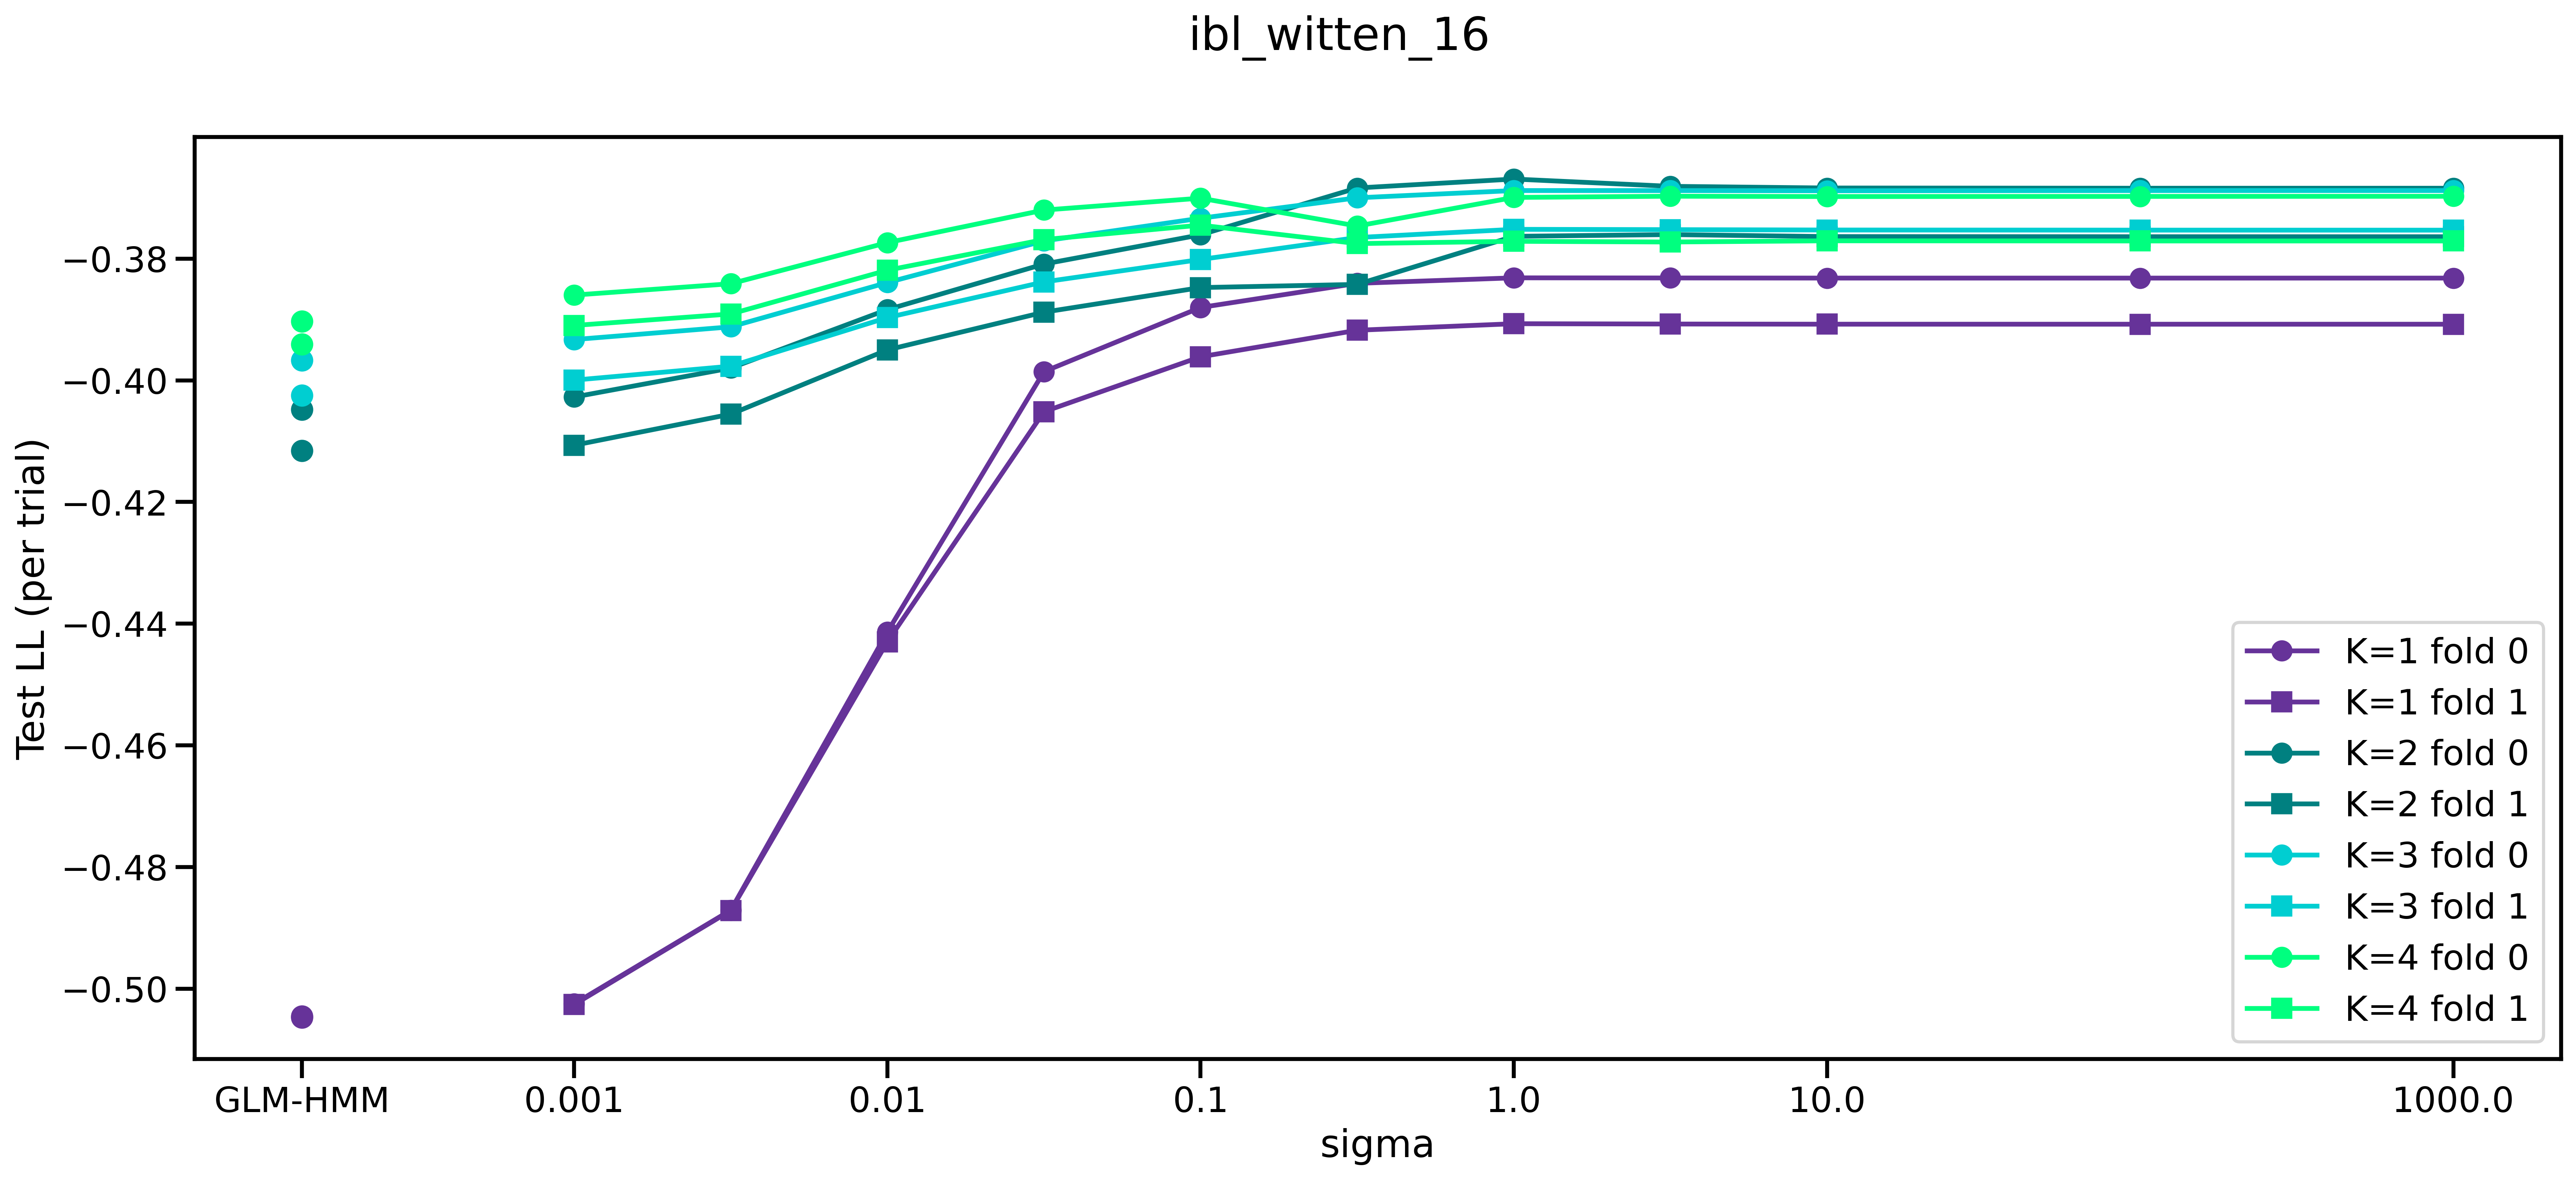

In [53]:
ls = ['-o','-s']
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject}')
for K in range(1,5):
    for fold in range(0, fitFolds):
        plot_testLl_CV_sigma(testLl[fitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes, linestyle=ls[fold])

[0, 2, 1]


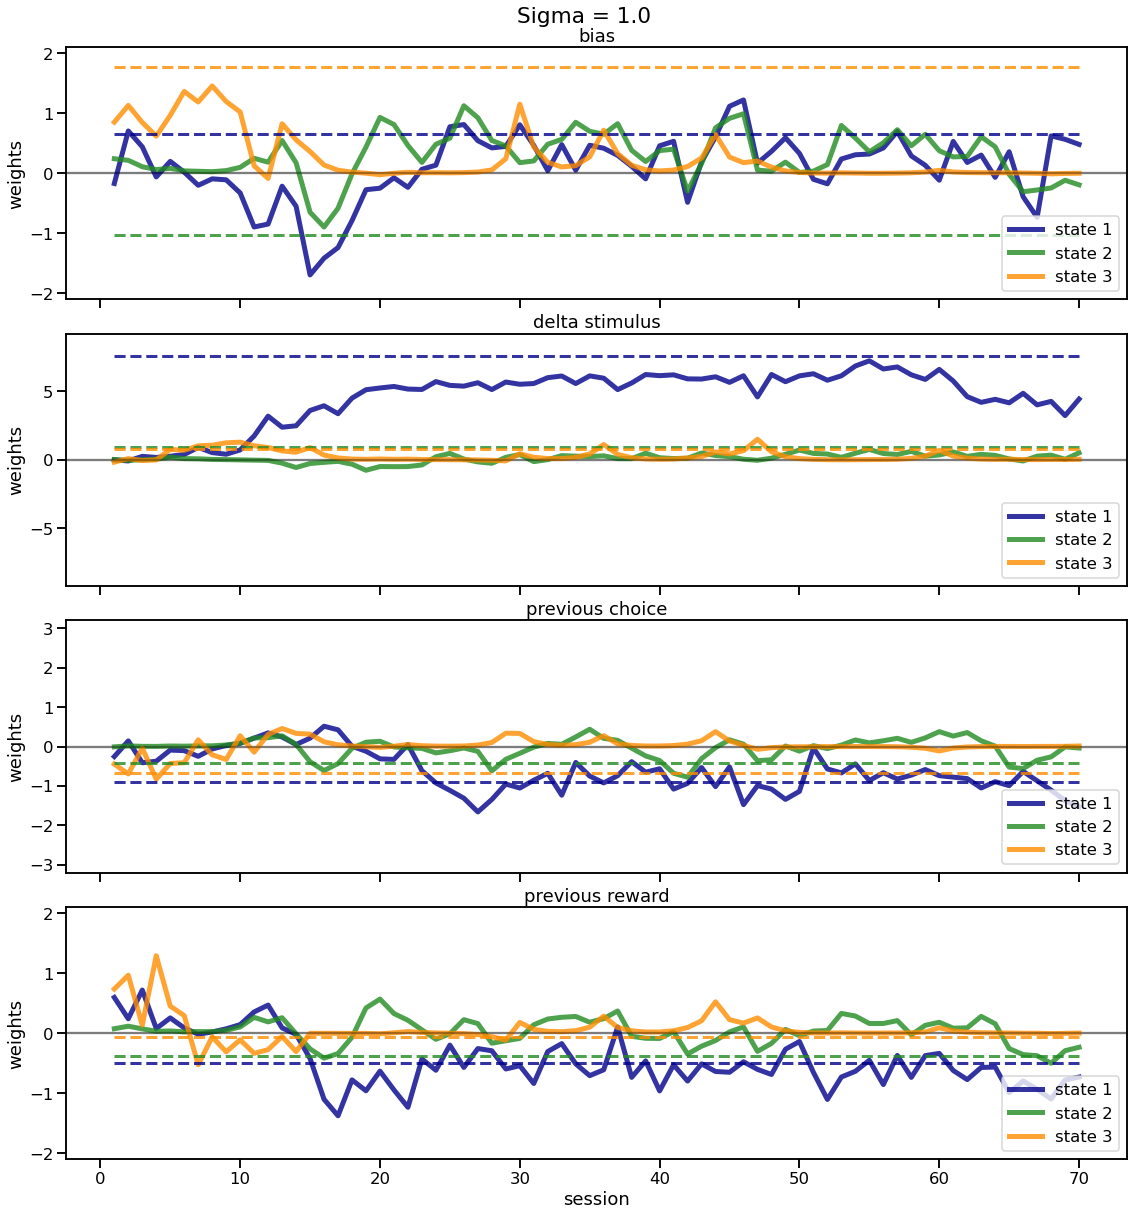

In [58]:
ind = 7
model = 5
fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
fig.suptitle(f'Sigma = {np.round(sigmaList[ind],2)}')
fig.tight_layout()
yLim = np.ones((D,2))
yLim[:,0] = -2.1
yLim[:,1] = 2.1
yLim[1,0] = -9.2
yLim[1,1] = 9.2
yLim[2,0] = -3.2
yLim[2,1] = 3.2
sortedStateInd = get_states_order(allW[model][0], trainSessInd[0]) # in the GLM-HMM
print(sortedStateInd)
plotting_weights_per_feature(allW[model][ind], trainSessInd[5], axes, yLim=yLim, colors=colorsStates, labels=myFeatures[D%2], linewidth=5, linestyle='-', sortedStateInd=sortedStateInd)
plotting_weights_per_feature(allW[model][0], trainSessInd[5], axes, yLim=yLim, colors=colorsStates, labels=myFeatures[D%2], linewidth=3, linestyle='--', legend=False, sortedStateInd=sortedStateInd)


In [12]:
# for K in range(1,4):
#     for fold in range(0, fitFolds):
#         fig, axes = plt.subplots(K, 1,figsize=(16,4*K+1), sharex=True)
#         fig.suptitle(f'{subject} K=1 dGLM-HMM with sigma={np.round(sigmaList[ind],2)}')
#         # fig.tight_layout()
#         # ind = 0
#         # plotting_weights_IBL(allW[fitFolds*(K-1)+fold][ind], trainSessInd[fitFolds*(K-1)+fold], axes, yLim=[-7,7], colors=colorsFeatures[D%2], labels=[None for x in range(0,D)], linewidth=4, linestyle='--')
#         ind = 7
#         plotting_weights_IBL(allW[fitFolds*(K-1)+fold][ind], trainSessInd[fitFolds*(K-1)+fold], axes, yLim=[-7,7], colors=colorsFeatures[D%2], labels=myFeatures[D%2])

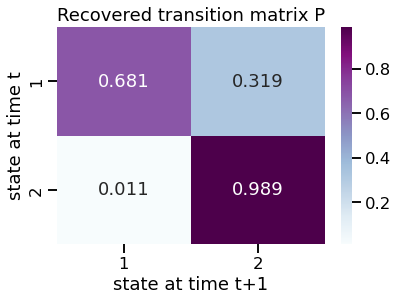

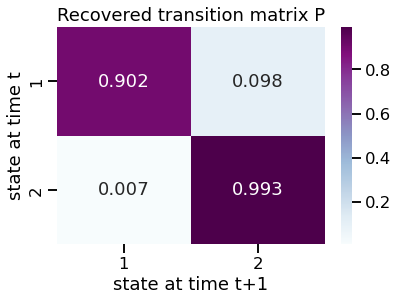

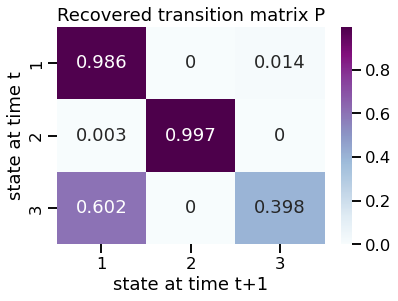

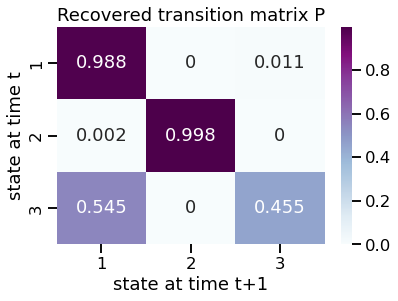

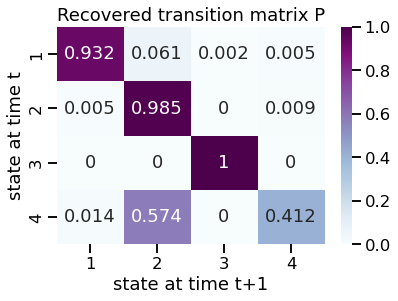

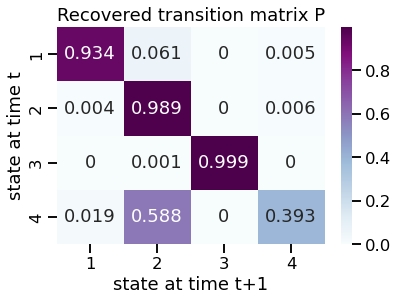

In [56]:
ind = 7
for K in range(1,5):
    for fold in range(0, fitFolds):
        if (K>1):
            fig, axes = plt.subplots()
            sortedStateInd = get_states_order(allW[2*(K-1)+fold][0], trainSessInd[0]) # in the GLM-HMM
            plot_transition_matrix(allP[2*(K-1)+fold][ind], sortedStateInd=range(K)) # not sorted

### Averaging across folds the testLL

In [8]:
# Reading models for following hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2
D = 4

# to tweak for different models:
sessStop = -1 # sessStop in [40,-1]
subject = 'ibl_witten_15' # subject in ['ibl_witten_15','ibl_witten_16']

avgTestLl = []
allP = [] 
allW = [] 
trainSessInd = []
for K in range(1,5):
    testLl = []
    for fold in range(0, fitFolds):
        testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))

NameError: name 'initParam' is not defined

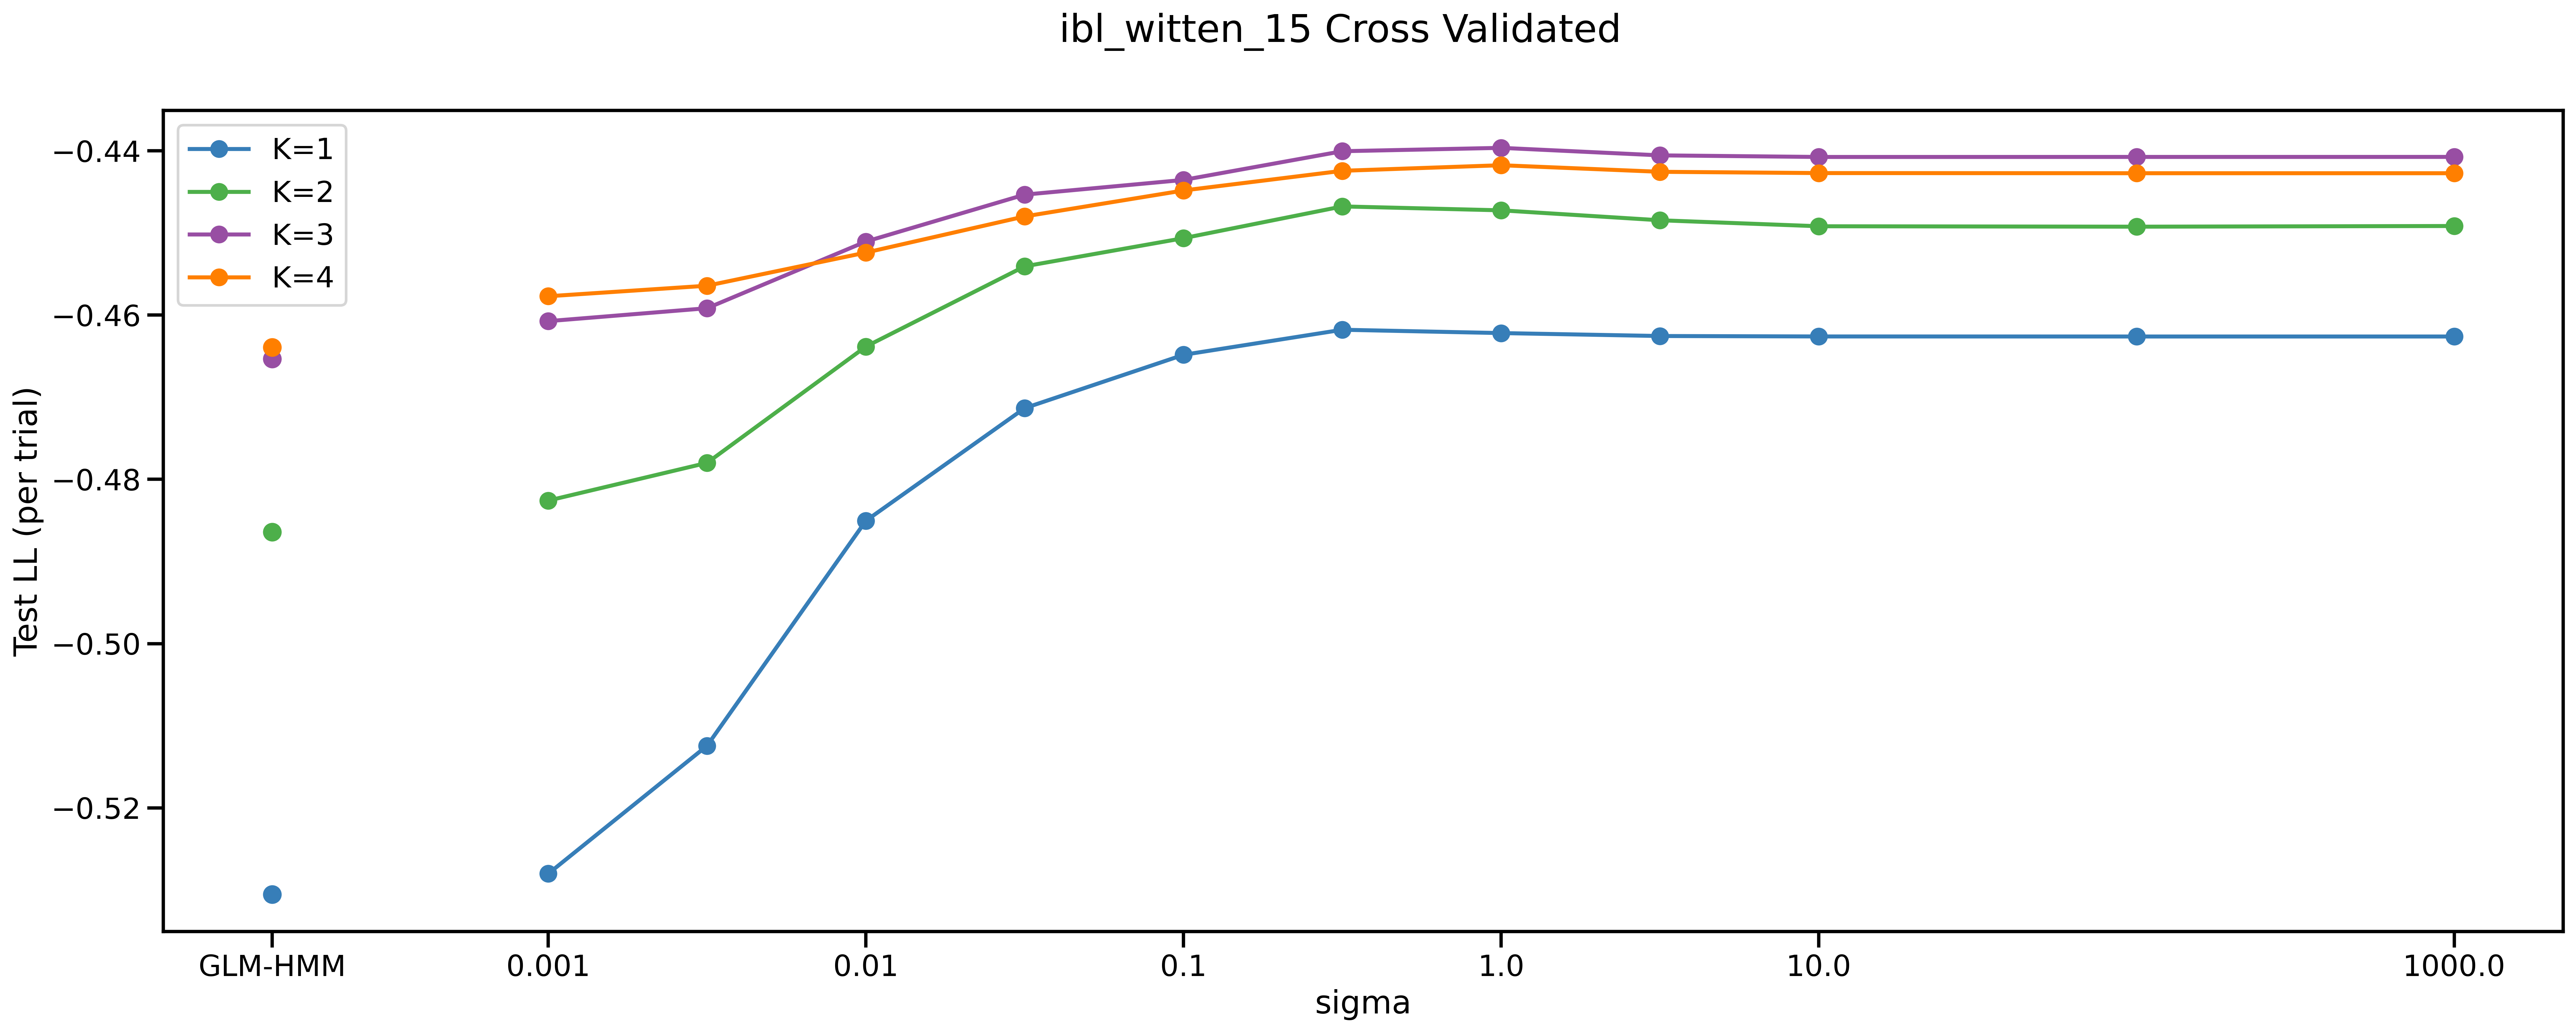

In [24]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated')
fig.tight_layout()
for K in range(1,5):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K], axes=axes)

In [13]:
ind = 6
K = 3
fold = 0
x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=splitFolds, blocks=10, random_state=1)
N = trainX[fold].shape[0]
D = trainX[fold].shape[1]
C = 2

dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
gamma = dGLM_HMM.get_posterior_latent(allP[fitFolds*(K-1)+fold][ind], np.ones((K))/K, allW[fitFolds*(K-1)+fold][ind], trainX[fold], trainY[fold], trainSessInd[fold])
# plot_posteior_latent(gamma, trainSessInd[0], sessions = [7,22,35])

# Looking at model performance for all animals together

In [6]:
# to tweak for different fit models:
D = 5 # D in [3,4,5]
sessStop = -1 # sessStop in [40,-1]
initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one

# these hyperparameters are the same across models
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

for subject in ['ibl_witten_02','ibl_witten_03','ibl_witten_14','ibl_witten_15','ibl_witten_16']: # 'ibl_witten_02','ibl_witten_03',
    avgTestLl = []
    allP = [] 
    allW = [] 
    trainSessInd = []
    for K in range(1,5):
        testLl = []
        for fold in range(0, fitFolds):
            testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        avgTestLl.append(np.mean(testLl[:],axis=0))
    
    fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    fig.suptitle(f'{subject} Cross Validated')
    fig.tight_layout()
    for K in range(1,5):
        plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
    # # loading previously fit
    # testLl = []
    # allP = [] 
    # allW = [] 
    # trainSessInd = []
    # for K in range(1,4):
    #     for fold in range(0, fitFolds):
    #         testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
    #         allP.append(np.load(f'../data_IBL/P_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
    #         allW.append(np.load(f'../data_IBL/W_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
    #         trainSessInd.append(np.load(f'../data_IBL/trainSessInd_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '../data_IBL/testLl_ibl_witten_14_D=5_1_state_fold-0_multiple_sigmas_L2penaltyW=1_priorDirP=None_untilSession-1_init-all.npy'

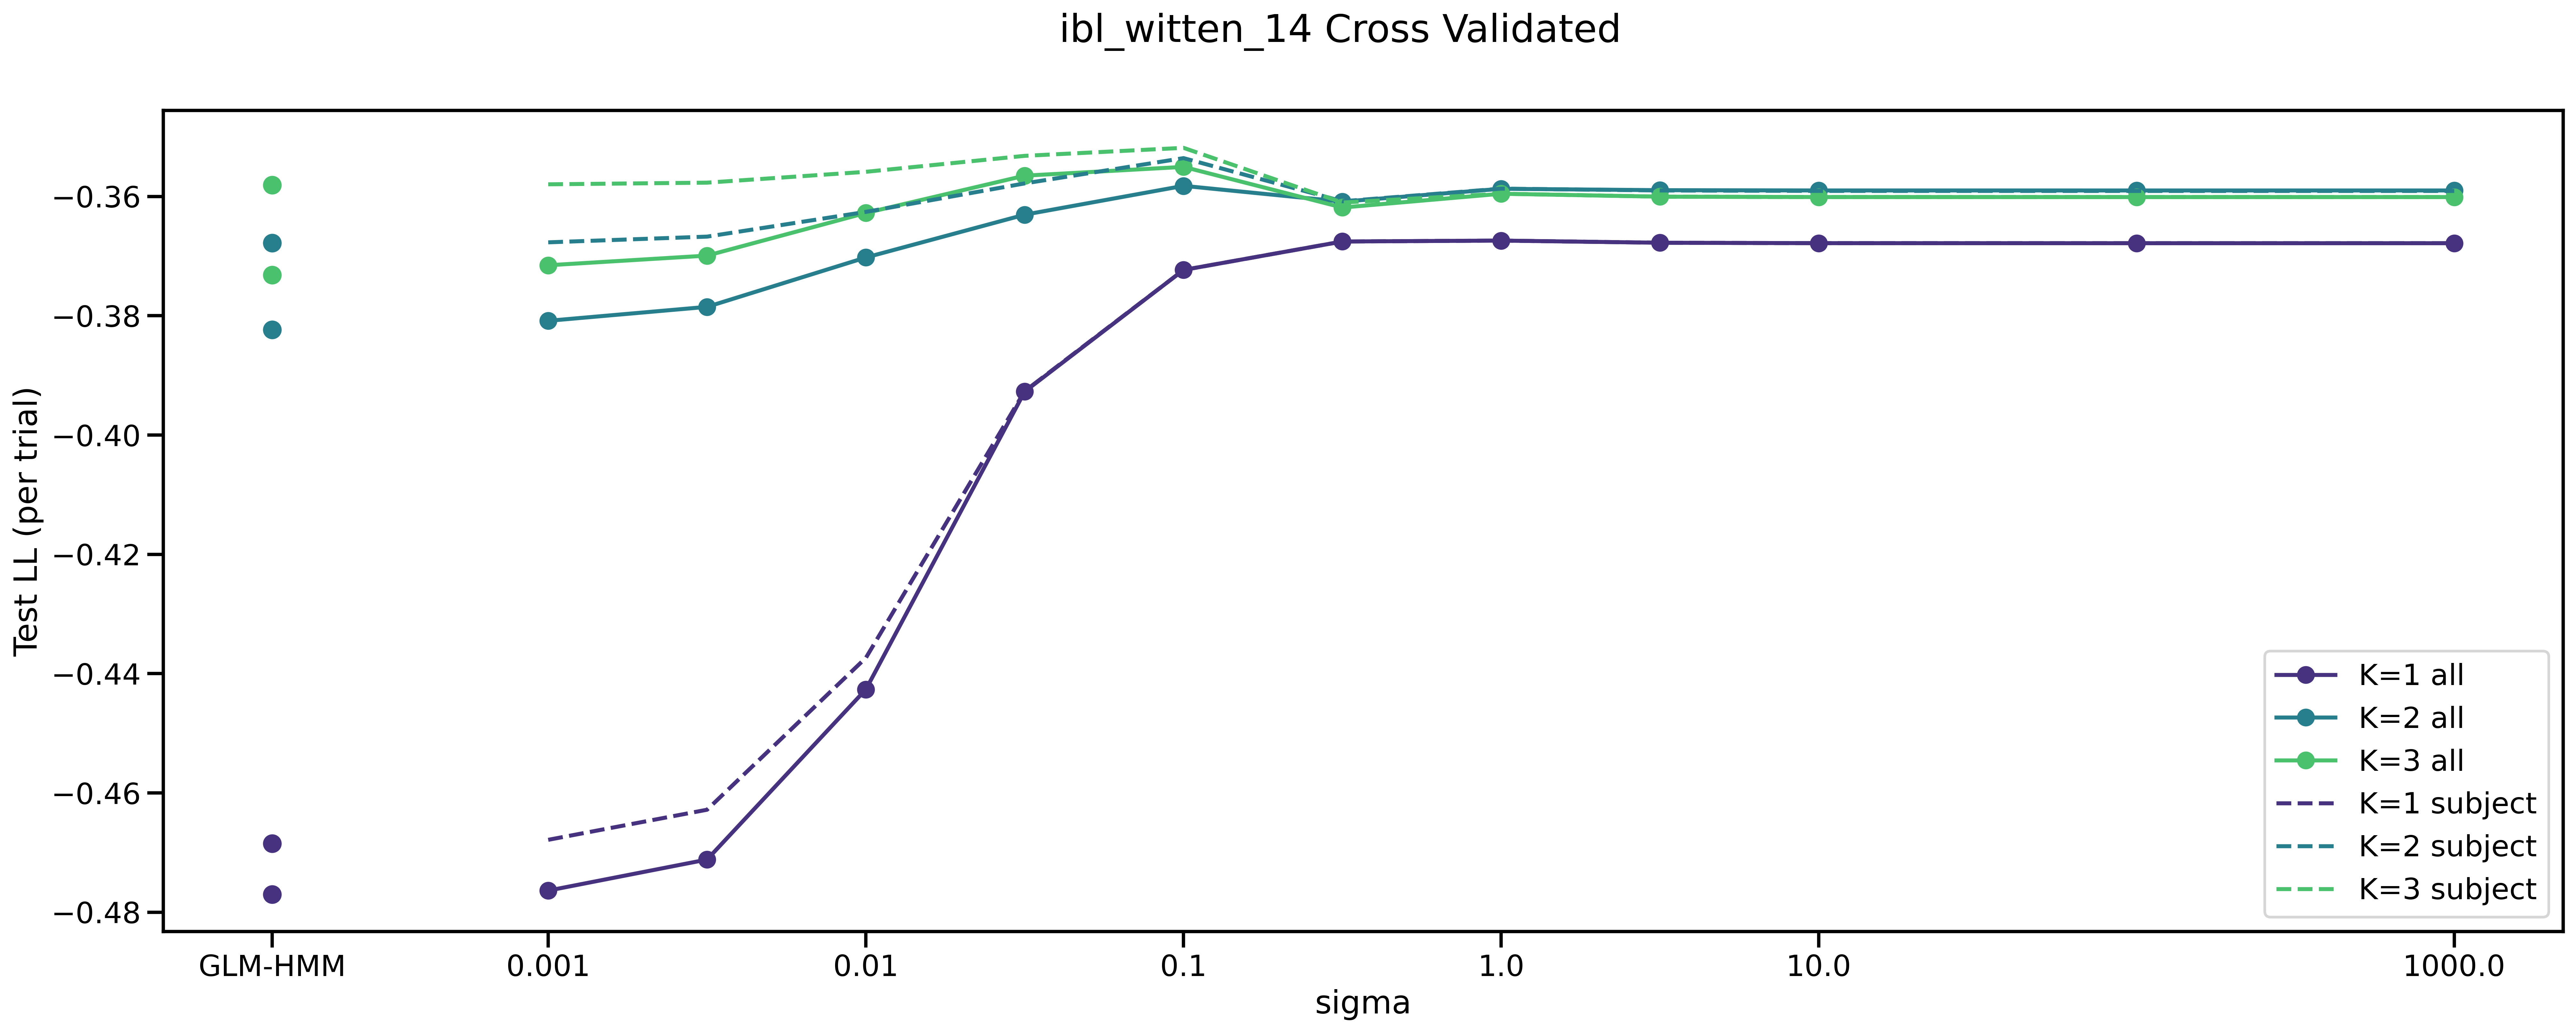

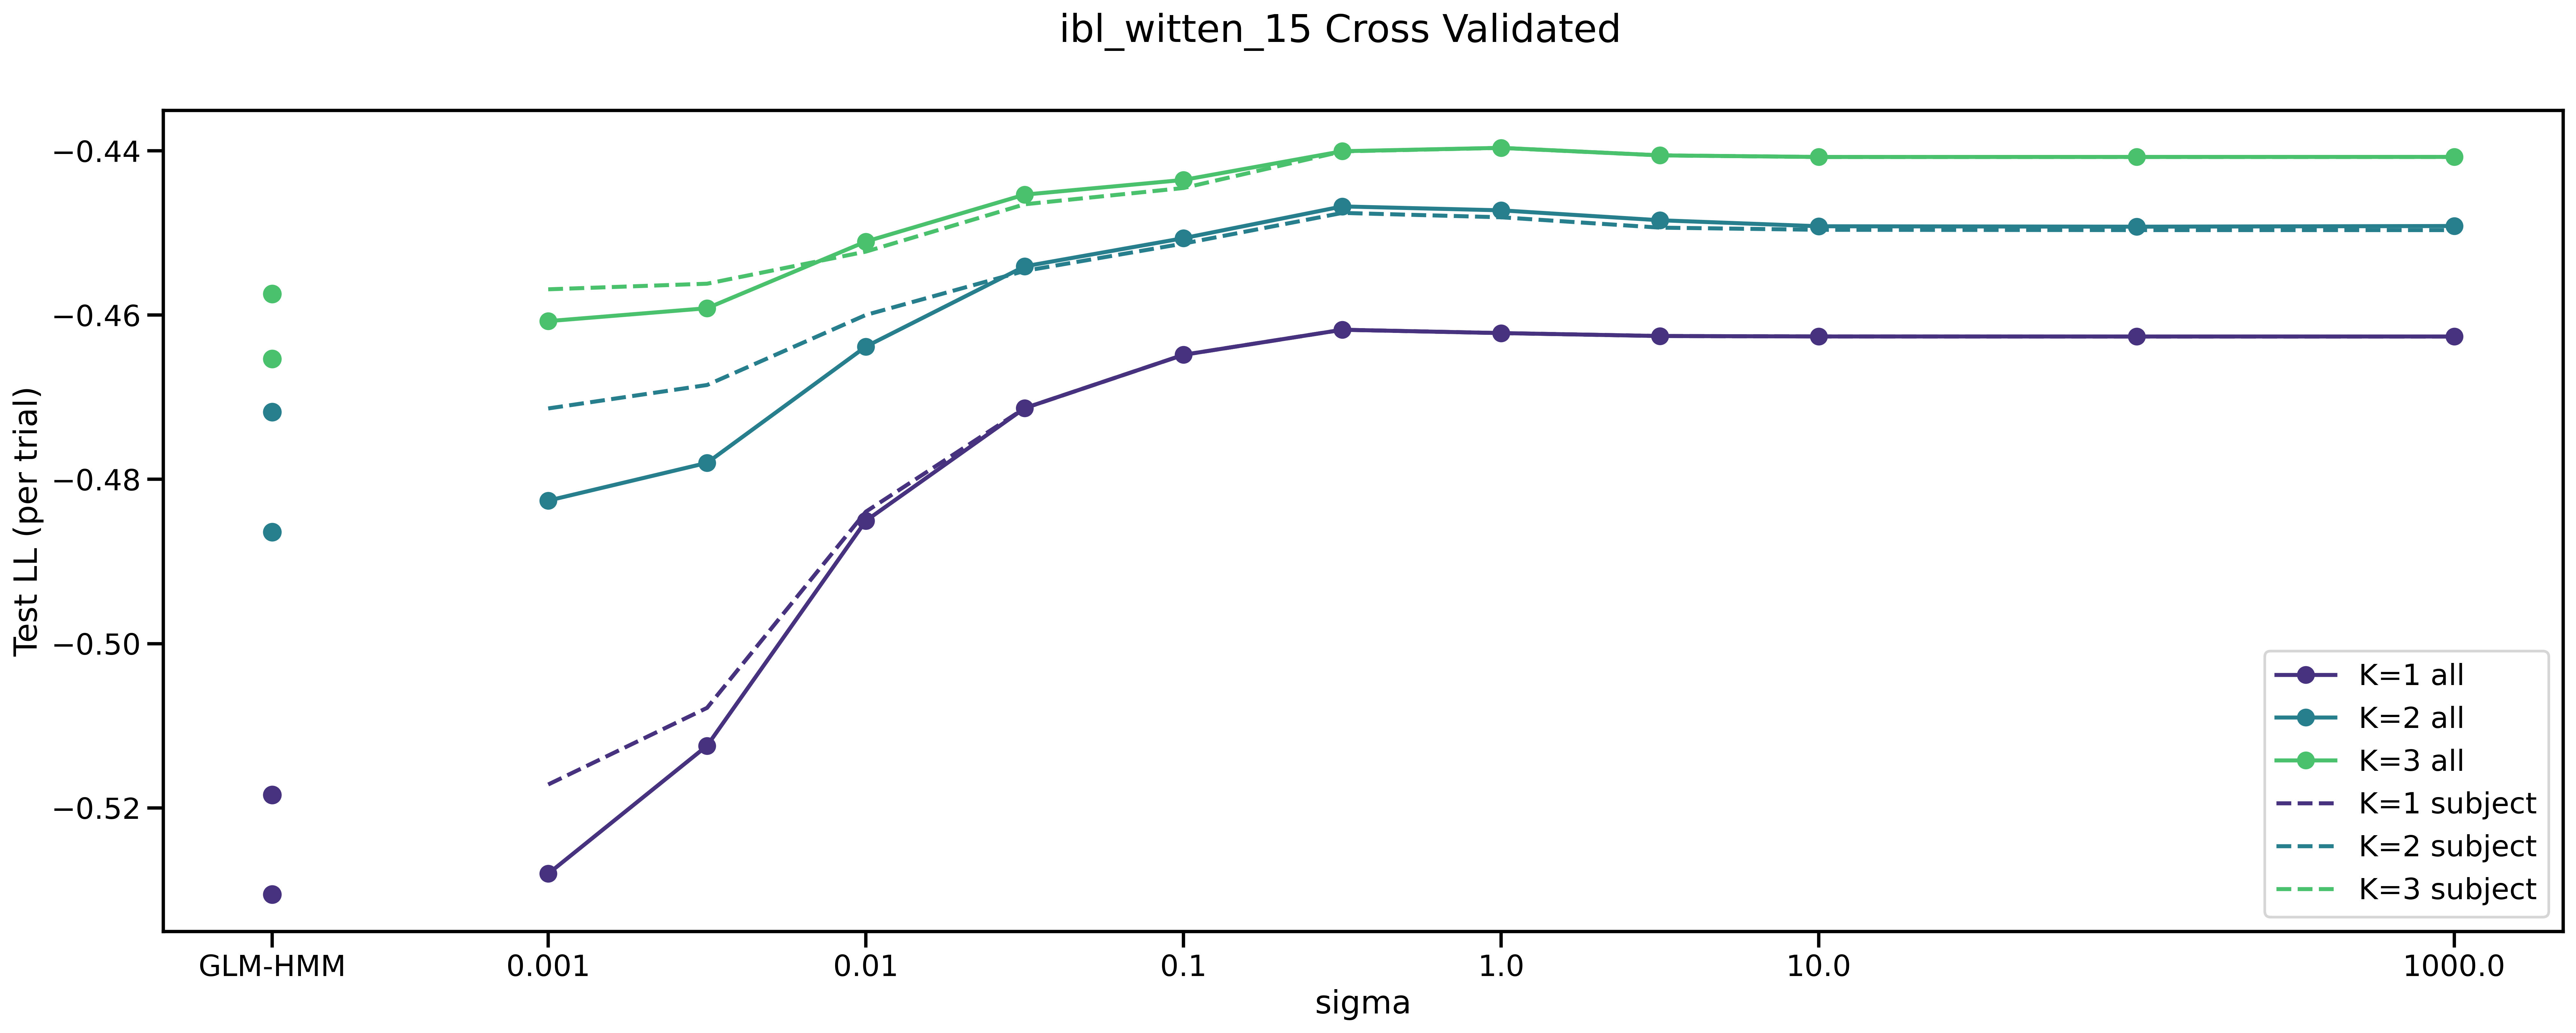

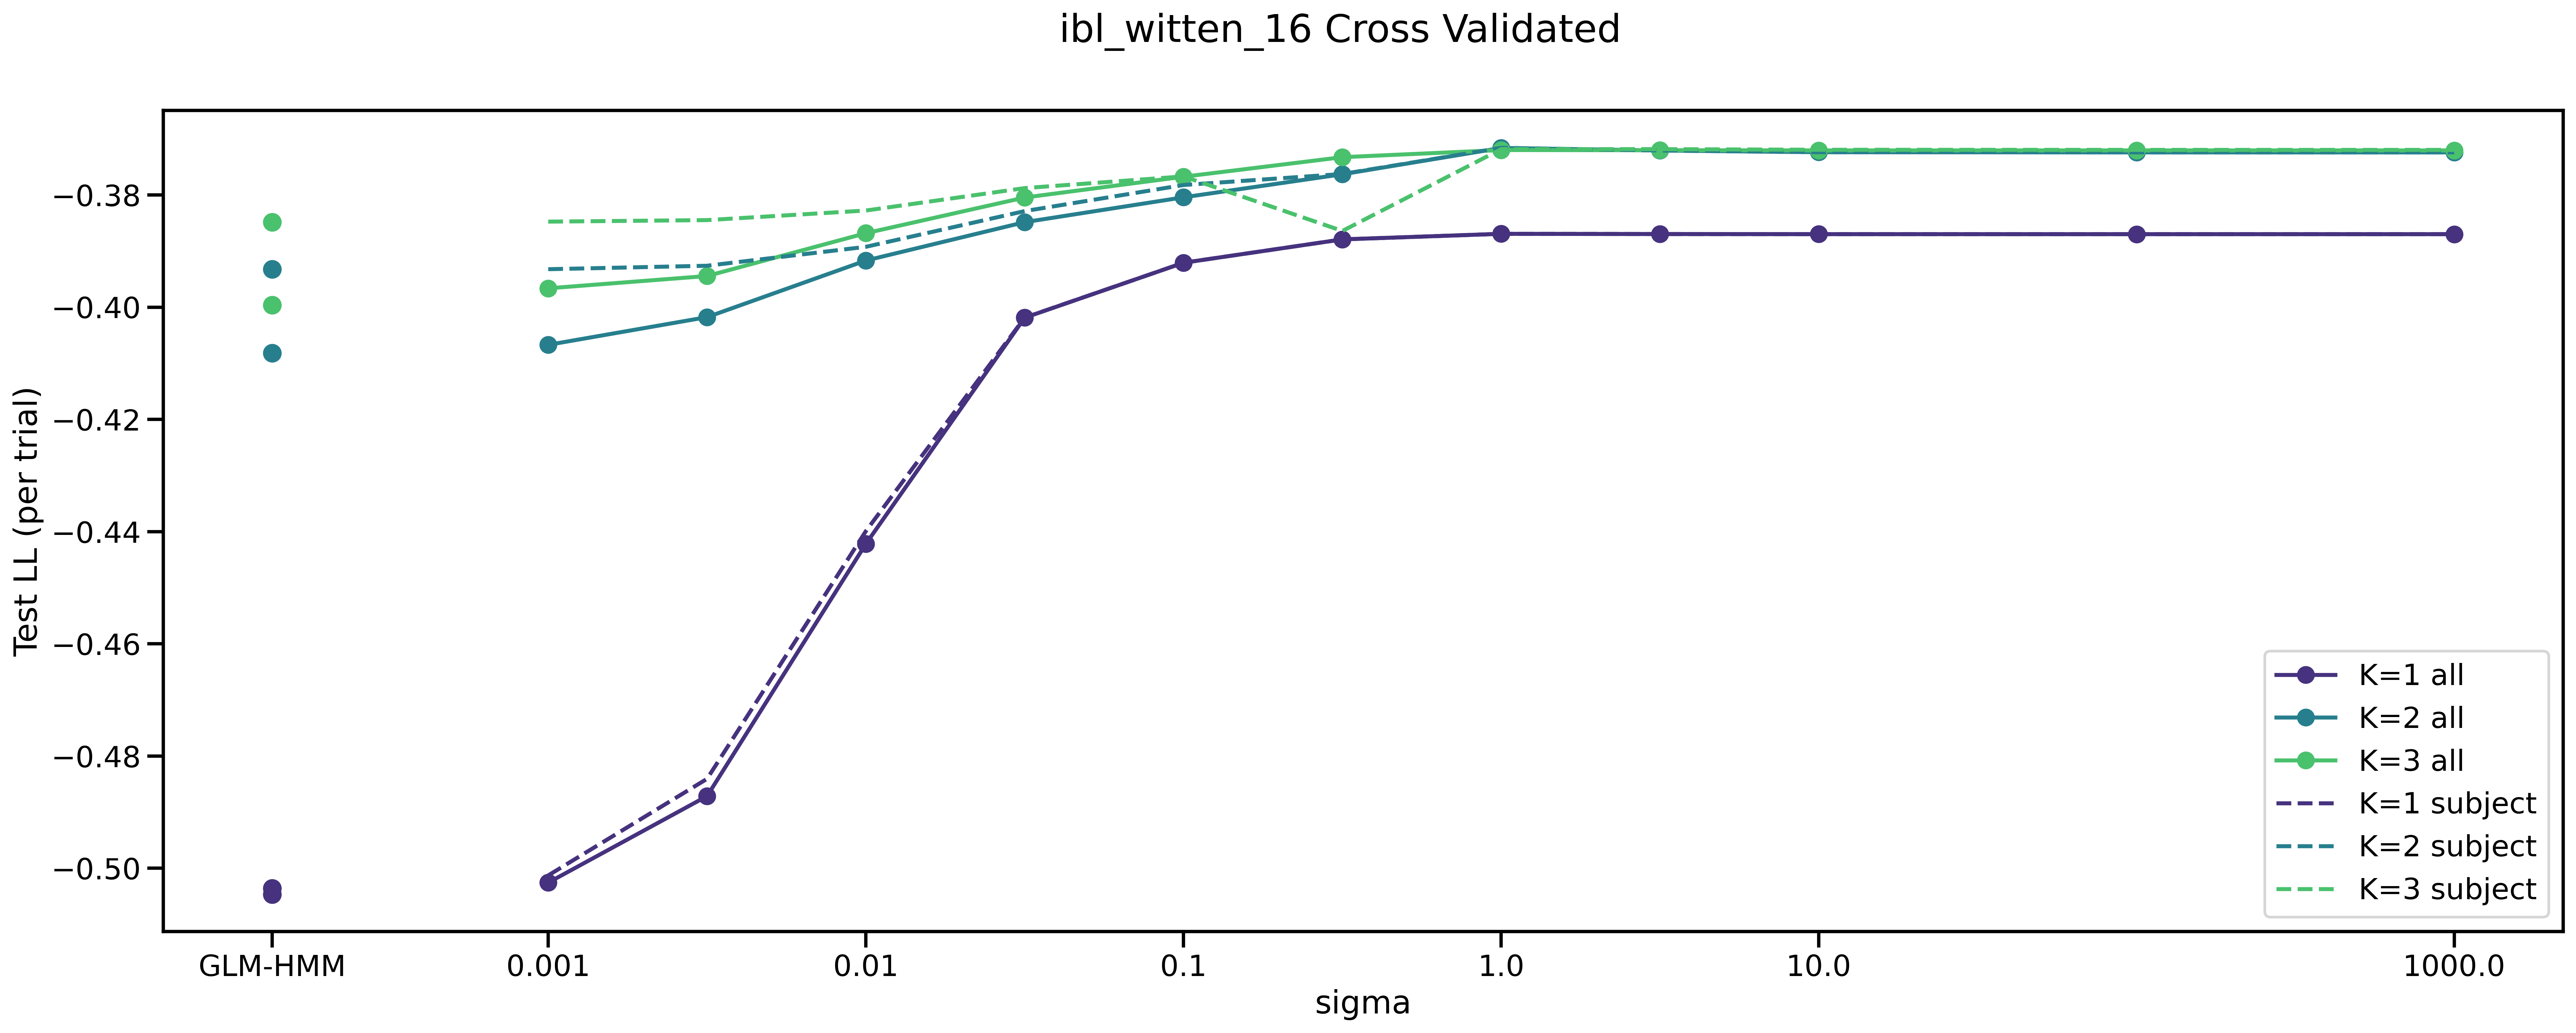

In [25]:
# to tweak for different fit models:
D = 4 # D in [3,4,5]
sessStop = -1 # sessStop in [40,-1]

# these hyperparameters are the same across models
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 4
fitFolds = 2

for subject in ['ibl_witten_14','ibl_witten_15','ibl_witten_16']:
    allP = [] 
    allW = [] 
    trainSessInd = []

    fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    fig.suptitle(f'{subject} Cross Validated')
    fig.tight_layout()

    avgTestLl = []
    for K in range(1,4):
        initParam = 'all' # initializing for best GLM-HMM fit from all animals or subject-specific one
        testLl = []
        for fold in range(0, fitFolds):
            testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        avgTestLl.append(np.mean(testLl[:],axis=0))
        plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K} all', color=2*(K-1), axes=axes)

    avgTestLl = []
    for K in range(1,4):
        initParam = 'subject' # initializing for best GLM-HMM fit from all animals or subject-specific one
        testLl = []
        for fold in range(0, fitFolds):
            testLl.append(np.load(f'../data_IBL/testLl_{subject}_D={D}_{K}_state_fold-{fold}_multiple_sigmas_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}_init-{initParam}.npy'))
        avgTestLl.append(np.mean(testLl[:],axis=0))
        plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K} subject', color=2*(K-1), axes=axes, linestyle='--')